# Import packages


In [1]:
import sys, os
sys.path.append('..') # add parent directory to path

import numpy as np
import pandas as pd
# from utils import processing as pr
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
torch.set_printoptions(edgeitems=2, linewidth=75)

from sklearn.preprocessing import MinMaxScaler

In [4]:
# ! pip install pyarrow fastparquet tqdm seaborn torch

In [5]:
# # Mount Google drive
# from google.colab import drive
# drive.mount('/content/drive')

# Load Test Data from Previous Notebook (03_combine_datasets.ipynb)
Consider only pickups from Taxi Zone 79 (East Village)

,PULocationID,pickup_datetime,counts
56544,79,2023-01-01 00:00:00-05:00,292.0
56545,79,2023-01-01 01:00:00-05:00,308.0
56546,79,2023-01-01 02:00:00-05:00,298.0
56547,79,2023-01-01 03:00:00-05:00,346.0
56548,79,2023-01-01 04:00:00-05:00,223.0


<AxesSubplot:xlabel='pickup_datetime'>

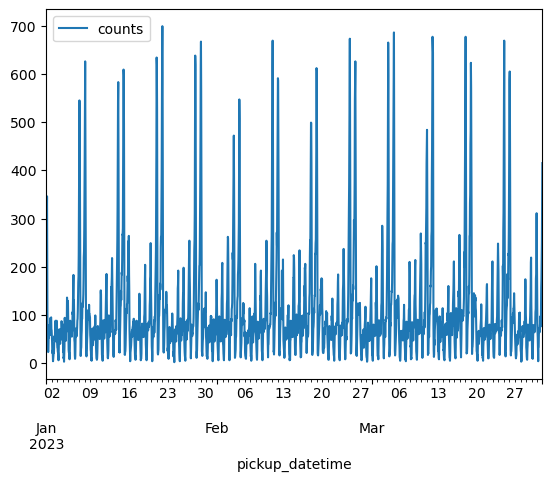

In [6]:
# load data
ts = pd.read_pickle('data/test/counts_yellow_2023-01_2023-03.pkl')
# ts = pd.read_pickle('./drive/MyDrive/Data Science Projects/taxi-forecast/notebooks/data/test/counts_yellow_2023-01_2023-03.pkl')

# taxi zone 79
ts_1 = ts[ts['PULocationID'].isin([79])].copy()
display(ts_1.head())
ts_1.plot(x = 'pickup_datetime', y = 'counts')

In [7]:
# basic processing
ts_1.drop(columns = ['PULocationID'], inplace = True) # PULocationID is constant, drop it
ts_1.set_index('pickup_datetime', inplace = True) # time series model packages require datetime index
display(ts_1)


,counts
pickup_datetime,
2023-01-01 00:00:00-05:00,292.0
2023-01-01 01:00:00-05:00,308.0
2023-01-01 02:00:00-05:00,298.0
2023-01-01 03:00:00-05:00,346.0
2023-01-01 04:00:00-05:00,223.0
...,...
2023-03-31 19:00:00-04:00,175.0
2023-03-31 20:00:00-04:00,213.0
2023-03-31 21:00:00-04:00,250.0


In [8]:
# Reindex the list of sequences --> resulting re-indexed list of sequence is ready to be batched while maintain the time line through batches
def group_chunks(ds, bs):
    m = len(ds) // bs
    new_ds = []
    for i in range(m):
        re_indexed_batch = list(ds[i + m*j] for j in range(bs))
        # print('batch length: ', len(re_indexed_batch))
        new_ds += list(ds[i + m*j] for j in range(bs))
    return new_ds

# Preprocess data for modelling

In [ ]:
data = ts_1['counts'].values
print(type(data))
print(data.shape)
print()

# Normalize data
scaler = MinMaxScaler()
data = scaler.fit_transform(data.reshape(-1, 1))
print(type(data))
print(data.shape)
print()

# Convert data to PyTorch tensors
data = torch.tensor(data, dtype=torch.float32)

In [9]:
sl = 50 # size of each slide (over time)
batch_size = 10

# Prepare the series into list of sequences (pair of input and target sequences)
data = [(data[i:i+sl], data[i+1:i+sl+1]) for i in range(0,len(data)-sl-1,sl)]
print(type(data))
print('N samples: ', len(data))
print('First sample: ', data[0])
print()

# Create Train and Validation sets - fix cutoff index to drop last few obs that are not enough to formm a batch
cut = int(len(data) * 0.8)
print('N samples in train set: ', len(data[:cut]))
print('N samples in validation set: ', len(data[cut:]))
print()

cut_train = cut - (cut % batch_size)
remain = len(data)-cut_train
cut_valid =  remain - (remain % batch_size)

# Create DataLoader for batch processing
train_loader = DataLoader(data[:cut_train], batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(data[cut_train:cut_train + cut_valid], batch_size=batch_size, shuffle=False)

# Check size of Train and Validation sets in the dataloaders
print('N batches in train loader: ', len(list(train_loader)))
print('N batches in validation loader: ', len(list(valid_loader)))
print()


# shape of first batch: 2 stacks
print('shape of first batch (2 stacks) in train set: ')
print('shape of input stack: ', list(train_loader)[0][0].size()) # input
print('shape of target stack: ', list(train_loader)[0][1].size()) # target
print()

# first pair of input & target in the batch
print('first pair of input & target in the first batch in train set: ')
print(list(train_loader)[0][0][0]) # input
print(list(train_loader)[0][1][0]) # target

<class 'numpy.ndarray'>
(2159,)

<class 'numpy.ndarray'>
(2159, 1)

<class 'list'>
N samples:  43
First sample:  (tensor([[0.4161],
        [0.4390],
        [0.4247],
        [0.4935],
        [0.3171],
        [0.0746],
        [0.0516],
        [0.0359],
        [0.0301],
        [0.0359],
        [0.0775],
        [0.0732],
        [0.0918],
        [0.1105],
        [0.0976],
        [0.0803],
        [0.1306],
        [0.1090],
        [0.1004],
        [0.1162],
        [0.1320],
        [0.1334],
        [0.0990],
        [0.0947],
        [0.0760],
        [0.0603],
        [0.0273],
        [0.0344],
        [0.0244],
        [0.0029],
        [0.0115],
        [0.0201],
        [0.0287],
        [0.0273],
        [0.0516],
        [0.0775],
        [0.0717],
        [0.0646],
        [0.0933],
        [0.1205],
        [0.1234],
        [0.0933],
        [0.0617],
        [0.0818],
        [0.1191],
        [0.1234],
        [0.1205],
        [0.0574],
        [0.0430],
    

# Modelling

## RNN

In [11]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.h = torch.zeros(num_layers, batch_size, hidden_size)

    def forward(self, x):
        out, h = self.rnn(x, self.h)
        self.h = h.detach()
        out = self.fc(out)
        return out

    def reset(self): self.h.zero_()

In [12]:
input_size = 1
hidden_size = 50
output_size = 1
num_layers = 1


model = RNNModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-3)


In [13]:
# Training loop for single series RNN/LSTM
num_epochs = 100

## to keep track of if validation loss went up
times_valid_loss_went_up_in_a_row = 0

## an initial value
min_valid_loss = float("inf")

valid_loss_list = []

for epoch in range(num_epochs):
    ## Train
    model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        preds = model(batch_X)
        train_loss = criterion(preds, batch_y)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_train_loss += train_loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    model.reset()

    ## Validate
    model.eval()
    epoch_valid_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in valid_loader:
            preds = model(batch_X)
            valid_loss = criterion(preds, batch_y)

            epoch_valid_loss += valid_loss.item()

    avg_valid_loss = epoch_valid_loss / len(valid_loader)
    model.reset()

    ## print out Train and Valiation loss for every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}')

    ## Early Stopping: check if the error went up or down
    valid_loss_list.append(avg_valid_loss)

    # if it went down
    if valid_loss_list[-1] < min_valid_loss:
        # record the new minimum val error
        min_valid_loss = valid_loss_list[-1]

        # reset our up counter
        times_valid_loss_went_up_in_a_row = 0
    # if it went up
    else:
        # add to the counter
        times_valid_loss_went_up_in_a_row = times_valid_loss_went_up_in_a_row + 1
        # if this is the 20th time in a row it has gone up
        if times_valid_loss_went_up_in_a_row == 20:
            # stop early
            break

Epoch [10/100], Train Loss: 0.0109, Validation Loss: 0.0114
Epoch [20/100], Train Loss: 0.0056, Validation Loss: 0.0061
Epoch [30/100], Train Loss: 0.0043, Validation Loss: 0.0047
Epoch [40/100], Train Loss: 0.0036, Validation Loss: 0.0040
Epoch [50/100], Train Loss: 0.0032, Validation Loss: 0.0036
Epoch [60/100], Train Loss: 0.0029, Validation Loss: 0.0033
Epoch [70/100], Train Loss: 0.0027, Validation Loss: 0.0032
Epoch [80/100], Train Loss: 0.0027, Validation Loss: 0.0030
Epoch [90/100], Train Loss: 0.0024, Validation Loss: 0.0028
Epoch [100/100], Train Loss: 0.0023, Validation Loss: 0.0026


Test Loss: 0.0026


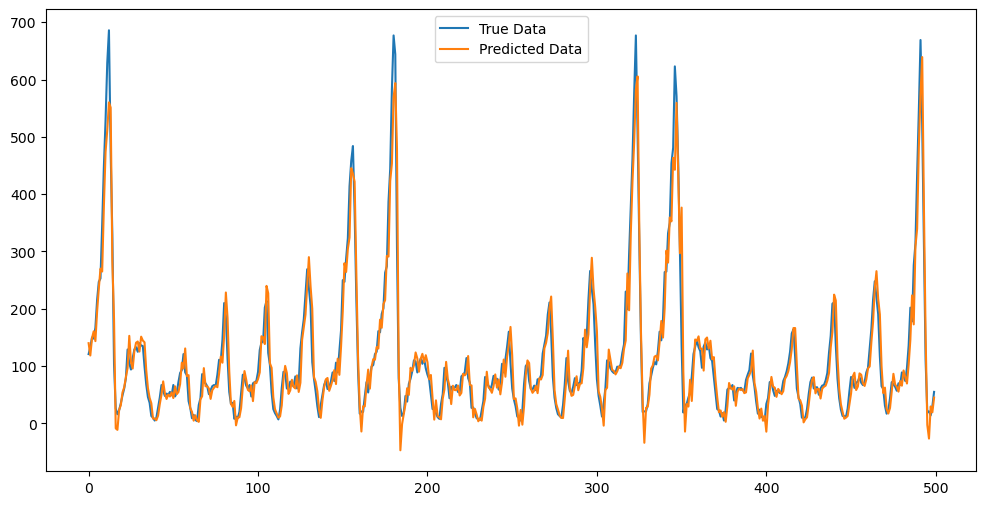

In [14]:
model.eval()
with torch.no_grad():
    test_preds = []
    test_labels = []

    for batch_X, batch_y in valid_loader:
        preds = model(batch_X)
        test_preds.append(preds)
        test_labels.append(batch_y)

    test_preds = torch.cat(test_preds, dim=0)
    test_labels = torch.cat(test_labels, dim=0)
    test_loss = criterion(test_preds, test_labels)
    print(f'Test Loss: {test_loss.item():.4f}')

    # Inverse transform to get the original scale
    test_preds = scaler.inverse_transform(test_preds.numpy().reshape(-1, 1))
    test_labels = scaler.inverse_transform(test_labels.numpy().reshape(-1, 1))

    plt.figure(figsize=(12, 6))
    plt.plot(range(len(test_labels)), test_labels, label='True Data')
    plt.plot(range(len(test_preds)), test_preds, label='Predicted Data')
    plt.legend()
    plt.show()


## LSTM

In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.h = [torch.zeros(num_layers, batch_size, hidden_size) for _ in range(2)]

    def forward(self, x):
        out, h = self.lstm(x, self.h)
        self.h = [h_.detach() for h_ in h]
        out = self.fc(out)
        return out

    def reset(self):
        for h in self.h: h.zero_()

In [16]:
input_size = 1
hidden_size = 50
output_size = 1
num_layers = 2

model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-3)


In [17]:
num_epochs = 1000

## to keep track of if validation loss went up
times_valid_loss_went_up_in_a_row = 0

## an initial value
min_valid_loss = float("inf")

valid_loss_list = []

for epoch in range(num_epochs):
    ## Train
    model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        preds = model(batch_X)
        train_loss = criterion(preds, batch_y)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_train_loss += train_loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    model.reset()

    ## Validate
    model.eval()
    epoch_valid_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in valid_loader:
            preds = model(batch_X)
            valid_loss = criterion(preds, batch_y)

            epoch_valid_loss += valid_loss.item()

    avg_valid_loss = epoch_valid_loss / len(valid_loader)
    model.reset()

    ## print out Train and Valiation loss for every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}')

    ## Early Stopping: check if the error went up or down
    valid_loss_list.append(avg_valid_loss)

    # if it went down
    if valid_loss_list[-1] < min_valid_loss:
        # record the new minimum val error
        min_valid_loss = valid_loss_list[-1]

        # reset our up counter
        times_valid_loss_went_up_in_a_row = 0
    # if it went up
    else:
        # add to the counter
        times_valid_loss_went_up_in_a_row = times_valid_loss_went_up_in_a_row + 1
        # if this is the 20th time in a row it has gone up
        if times_valid_loss_went_up_in_a_row == 20:
            # stop early
            break

Epoch [10/1000], Train Loss: 0.0249, Validation Loss: 0.0269
Epoch [20/1000], Train Loss: 0.0120, Validation Loss: 0.0117
Epoch [30/1000], Train Loss: 0.0032, Validation Loss: 0.0030
Epoch [40/1000], Train Loss: 0.0023, Validation Loss: 0.0024
Epoch [50/1000], Train Loss: 0.0020, Validation Loss: 0.0024
Epoch [60/1000], Train Loss: 0.0019, Validation Loss: 0.0023
Epoch [70/1000], Train Loss: 0.0019, Validation Loss: 0.0023
Epoch [80/1000], Train Loss: 0.0019, Validation Loss: 0.0022
Epoch [90/1000], Train Loss: 0.0018, Validation Loss: 0.0023


Test Loss: 0.0025


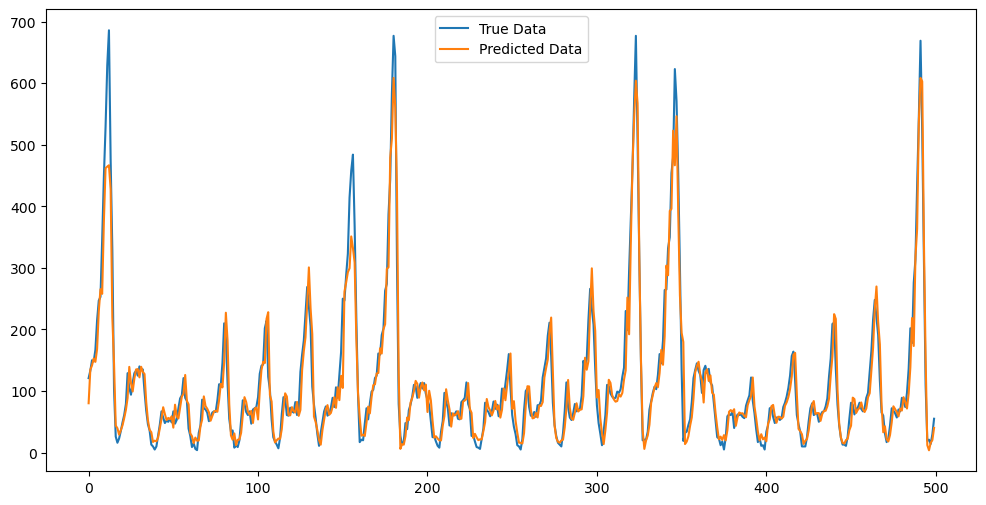

In [18]:
model.eval()
with torch.no_grad():
    test_preds = []
    test_labels = []

    for batch_X, batch_y in valid_loader:
        preds = model(batch_X)
        test_preds.append(preds)
        test_labels.append(batch_y)

    test_preds = torch.cat(test_preds, dim=0)
    test_labels = torch.cat(test_labels, dim=0)
    test_loss = criterion(test_preds, test_labels)
    print(f'Test Loss: {test_loss.item():.4f}')

    # Inverse transform to get the original scale
    test_preds = scaler.inverse_transform(test_preds.numpy().reshape(-1, 1))
    test_labels = scaler.inverse_transform(test_labels.numpy().reshape(-1, 1))

    plt.figure(figsize=(12, 6))
    plt.plot(range(len(test_labels)), test_labels, label='True Data')
    plt.plot(range(len(test_preds)), test_preds, label='Predicted Data')
    plt.legend()
    plt.show()
